In [1]:
#!pip install geopandas
#!pip install mapclassify
#!pip install termcolor

In [2]:
# Super Market Management System
from mysql.connector import connect, Error
from getpass import getpass
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import geopandas as gpd
from termcolor import colored

import warnings

warnings.filterwarnings('ignore')


In [3]:
try:
        conn = connect(
            host='localhost',
            user='root',
            password=getpass('Enter password'),
            database='kwikmart'
        );
        print("Welcome to Kwik Mart!!")
except Error as e:
        print(e)

Enter password········
Welcome to Kwik Mart!!


### Looking at the category wise revenue across all stores

In [4]:
def getCategoriesRevenue(conn, start_date, end_date):
    query='''
    SELECT c.category_name AS Category_Name ,SUM(bi.quantity * bi.net_price) AS Revenue
    FROM bill b
    JOIN bill_items bi ON bi.bill_id = b.bill_id
        AND b.bill_date >= %s and b.bill_date <= %s
    JOIN item i ON i.item_id = bi.item_id
    JOIN category c ON c.category_id = i.category_id
    GROUP BY Category_Name
    ORDER BY Revenue DESC
    ''';
    
    # function to add value labels
    def addlabels(x,y):
        for i in range(len(x)):
            amt = '$'+str(math.trunc(y[i]))
            plt.text(i, y[i]//4, amt, ha = 'center',
                     bbox = dict(facecolor = 'white', alpha =.8),
                    rotation = 90)
        
    value_tuple=(start_date, end_date);
    df = pd.read_sql(query, conn, params=[start_date, end_date])
    plt.figure(figsize=(15, 5))
    plt.bar(df.Category_Name, df.Revenue)
    plt.xticks(rotation=90)
    
    addlabels(df.Category_Name, df.Revenue)
    
    # Add labels and a title.
    plt.xlabel('Categories', labelpad=10, color='#333333',weight='bold')
    plt.ylabel('Net Revenue', labelpad=10, color='#333333',weight='bold')
    plt.title(f'Category wise revenue between [{start_date} , {end_date}]', pad=15, color='#333333',weight='bold')

    plt.show()

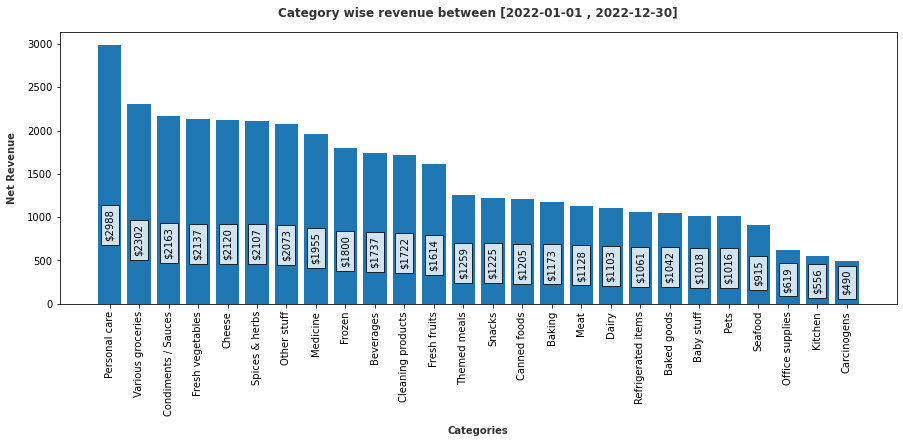

In [5]:
# calling getCategoriesRevenue function
getCategoriesRevenue(conn, '2022-01-01', '2022-12-30')

### State wise no of stores and revenue 

In [6]:
def numOfstoresVsRevenue(conn):
    query1 = '''
    Select t1.state, t1.numOfStores, t2.revenue from
    (select count(*) as numOfStores, store.state
    from store
    group by store.state
    order by store.state) t1 join 
    (    select store.state, SUM(revenue) as revenue
    from store left outer join (
    select bill.store_id, Sum(bill_items.quantity * bill_items.net_price) as revenue
    from bill, bill_items
    where bill.bill_id = bill_items.bill_id
    group by bill.store_id) temp
    on store.store_id = temp.store_id
    group by store.state) t2
    where t2.state = t1.state
    order by t1.numOfStores
    ''';
    
    df = pd.read_sql(query1, conn);
    return df

In [7]:
# calling function
df = numOfstoresVsRevenue(conn)
df.rename(columns={"state": "NAME"},inplace=True)
di = {"SouthDakota":"South Dakota", "WestVirginia":"West Virginia", "RhodeIsland":"Rhode Island", "NewHampshire":"New Hampshire", 
                "NewMexico":"New Mexico", "NorthDakota": "North Dakota","NewJersey":"New Jersey"}
df = df.replace({"NAME": di})

# getting latitude and longitude for each state
df_lat_long = pd.read_csv("US_States_lat_lon_final.csv")
df_states = df_lat_long.merge(df,on='NAME',how='outer')
df_states[["numOfStores","revenue"]] = df_states[["numOfStores","revenue"]].fillna(0)
df_states.head()

,NAME,lat,lon,numOfStores,revenue
0,Maryland,39.045753,-76.641273,3.0,1726.23
1,Iowa,42.032974,-93.581543,2.0,108.63
2,Delaware,39.000000,-75.500000,5.0,930.27
3,Ohio,40.367474,-82.996216,3.0,2491.55
4,Pennsylvania,41.203323,-77.194527,3.0,1019.02


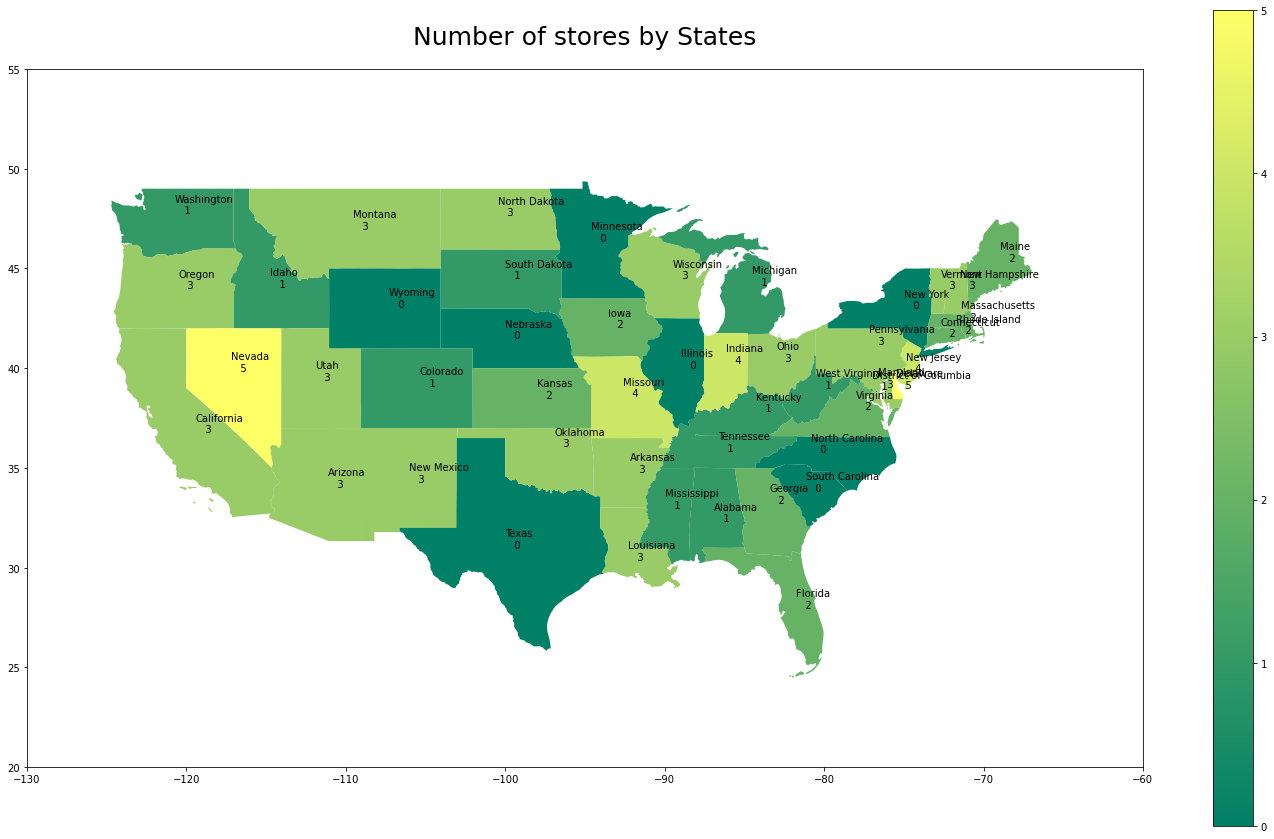

In [8]:
# url of our shape file 
path=r"C:\Users\agraw\Documents\Git\DS5110\Python implementation\cb_2018_us_state_20m"
# load the shape file using geopandas
geo_usa = gpd.read_file(path+'\cb_2018_us_state_20m.shp')

# merge usa_state data and geo_usa shapefile
geo_merge=geo_usa.merge(df_states,on='NAME',how='outer')

indexRow = geo_merge[ (geo_merge.NAME == 'Alaska') | (geo_merge.NAME == 'Hawaii') | (geo_merge.NAME == 'Puerto Rico')].index
geo_merge.drop(indexRow , inplace=True)
geo_merge.reset_index(drop=True, inplace=True)

# plot state wise number of stores
geo_merge.plot(column='numOfStores', figsize=(25, 15),legend=True,cmap='summer')
plt.xlim(-130,-60)
plt.ylim(20,55)
# add countries names and numbers 
for i in range(len(geo_merge)):
    plt.text(geo_merge.lon[i],geo_merge.lat[i],"{}\n   {}".format(geo_merge.NAME[i],int(geo_merge.numOfStores[i])),size=10)
plt.title('Number of stores by States',pad=25,fontsize=25)
plt.show()

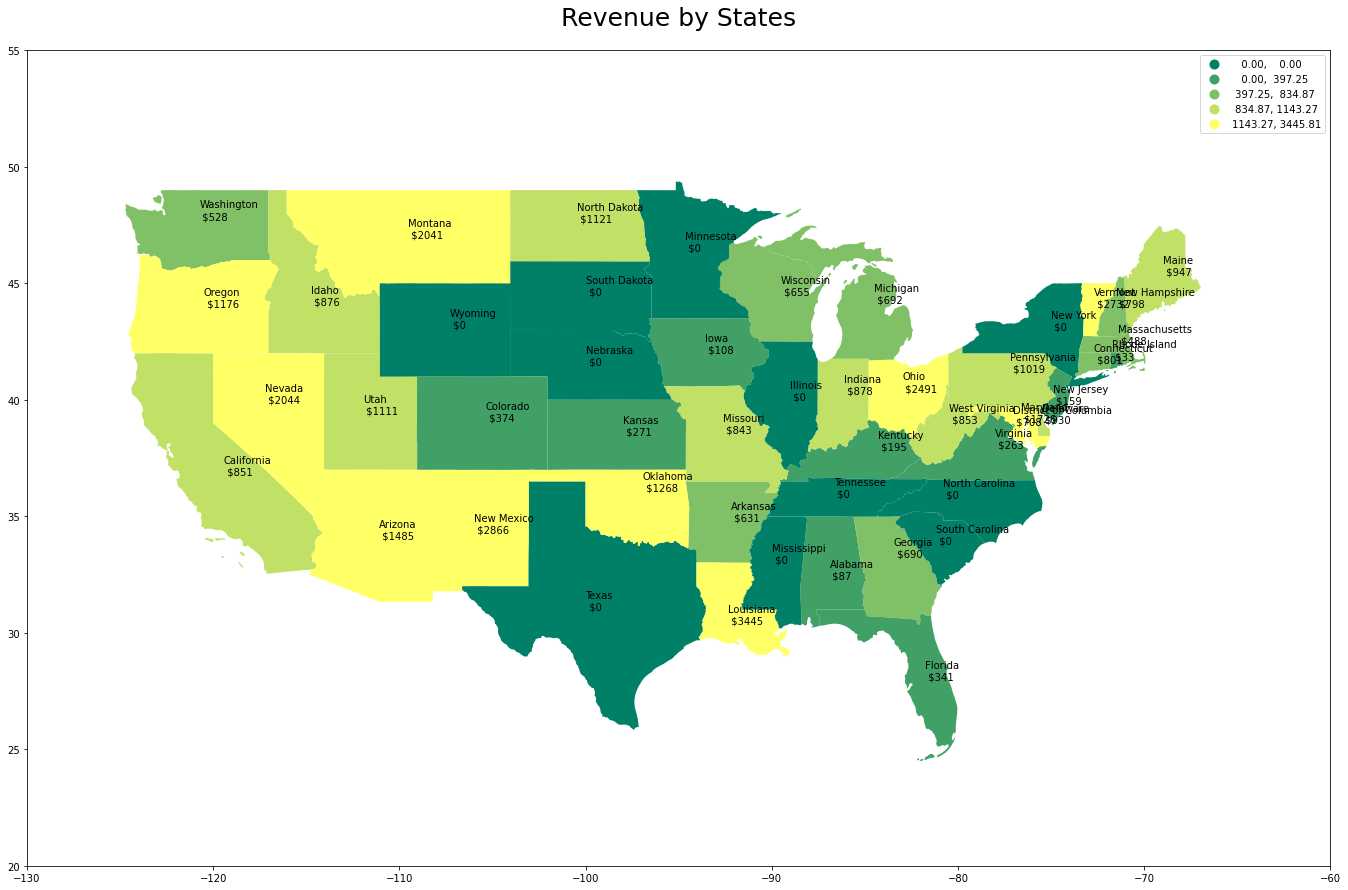

In [9]:
# plot state wise revenue
geo_merge.plot(column='revenue',scheme="quantiles", figsize=(25, 15),legend=True,cmap='summer')
plt.xlim(-130,-60)
plt.ylim(20,55)
# add countries names and numbers 
for i in range(len(geo_merge)):
    plt.text(geo_merge.lon[i],geo_merge.lat[i],\
             "\n{}\n ${}".format(geo_merge.NAME[i],int(geo_merge.revenue[i])),size=10)
plt.title('Revenue by States',pad=25,fontsize=25)
plt.show()

### Quarter-wise business performance based on Revenue

In [10]:
def revenueInEachQuarter(conn, year):
    query='''
    SELECT CEILING(MONTH(b.bill_date)/3) AS quarter, SUM(bi.net_price*bi.quantity) net_revenue
    FROM bill_items bi
    JOIN bill b ON b.bill_id = bi.bill_id
    WHERE b.bill_date LIKE %s
    GROUP BY 1
    ORDER BY quarter
    ''';
    
    value_tuple = (year+'%',)
    df = pd.read_sql(query, conn,params = value_tuple)
    idx = df[['net_revenue']].idxmax()
    myexplode = np.zeros(len(df.quarter))
    myexplode[idx[0]] = 0.1
    
    plt.figure(figsize=(7, 7))
    plt.pie(df.net_revenue, labels = df.quarter,autopct='%.0f%%', explode = myexplode)
    plt.title('Quarterly Revenue',pad=10,fontsize=15)

    plt.show()

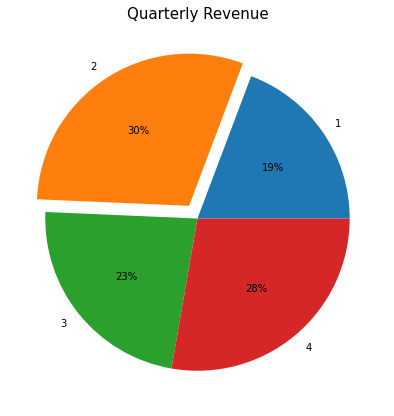

In [11]:
# pie-chart to visulize quarterly performance
revenueInEachQuarter(conn,'2022')